* [8.2. A COMPLETE EXAMPLE](#8.2.-A-COMPLETE-EXAMPLE)
* [8.4. EXAMPLE: DIFFERENCE OF BIASES](#8.4.-EXAMPLE:-DIFFERENCE-OF-BIASES)
* [8.6.1. Defning new likelihood functions](#8.6.1.-Defning-new-likelihood-functions)
* [Exercise 8.1](#Exercise-8.1)
* [Exercise 8.2](#Exercise-8.2)
* [Exercise 8.4](#Exercise-8.4)

## 8.2. A COMPLETE EXAMPLE

Python version of `Jags-ExampleScript.R`

In [1]:
# Load the data:
import pandas as pd

data_df = pd.read_csv('../datasets/z15N50.csv')
data_df.head(5)

,y
0,0
1,1
2,0
3,0
4,0


In [2]:
data = data_df['y'].values

In [3]:
# Define the model:

# set matplotlib inline so pymc3 plays nicely with jupyter
%matplotlib inline
import pymc3 as pm

with pm.Model() as model:
    # Priors for unknown model parameters
    theta = pm.Beta('theta', alpha=1, beta=1, transform=None)
    
    # Likelihood (sampling distribution) of observations
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    # define sampling method
    step = pm.Slice() # similar to Gibbs sampling
    # step = pm.Metropolis(S=0.2, tune=False)
    
    # burn in chains
    theta_init = sum(data)/len(data)
    start = {'theta': theta_init}
    trace = pm.sample(500, step=step, start=start, njobs=3, progressbar=False)
    
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=3)

 [-----------------100%-----------------] 10000 of 10000 complete in 19.5 sec

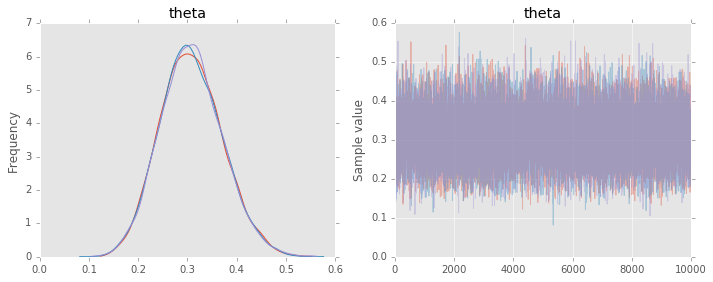

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

_ = pm.traceplot(trace, figsize=(10,4))

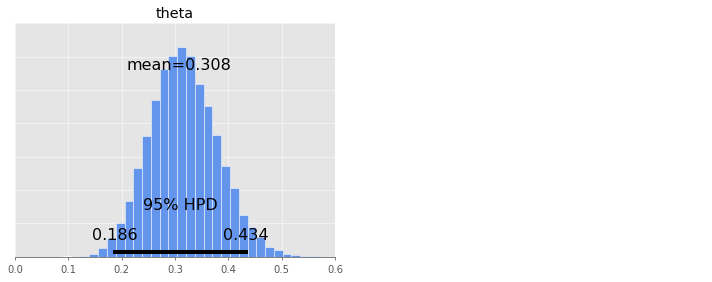

In [5]:
_ = pm.plot_posterior(trace, figsize=(10,4), color='cornflowerblue')

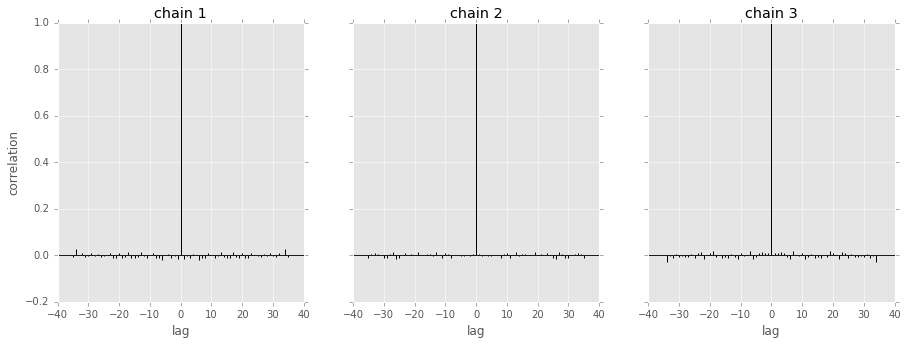

In [6]:
_ = pm.plots.autocorrplot(trace, max_lag=35, figsize=(15, 5), symmetric_plot=True)

## 8.4. EXAMPLE: DIFFERENCE OF BIASES

Python version of `Jags-Ydich-XnomSsubj-Mbernbeta-Example.R`

In [7]:
import numpy as np
from dbda2e_utils import plotPost

In [8]:
data_df = pd.read_csv('../datasets/z6N8z2N7.csv')
data_df.head(5)

,y,s
0,1,Reginald
1,0,Reginald
2,1,Reginald
3,1,Reginald
4,1,Reginald


In [9]:
data_df.groupby('s').count()

,y
s,
Reginald,8
Tony,7


In [10]:
# Define the model:
with pm.Model() as model:
    start = {}
    for name, group in data_df.groupby('s'):
        data = group['y'].values
        # Priors for unknown model parameters
        theta = pm.Beta('theta_'+name, alpha=2, beta=2, transform=None)
        # Likelihood (sampling distribution) of observations
        y = pm.Bernoulli('y_'+name, p=theta, observed=data)
        start['theta_'+name] = data.mean()

    # define sampling method
    step = pm.Slice() # similar to Gibbs sampling
    
    # burn in chains
    trace = pm.sample(500, step=step, start=start, njobs=4, progressbar=False)
    
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 10000 of 10000 complete in 53.7 sec

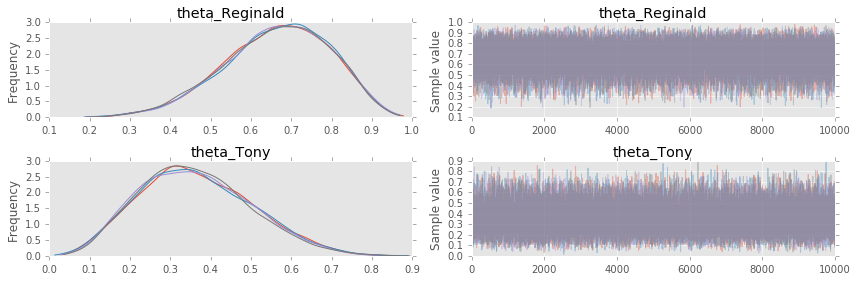

In [11]:
_ = pm.traceplot(trace)

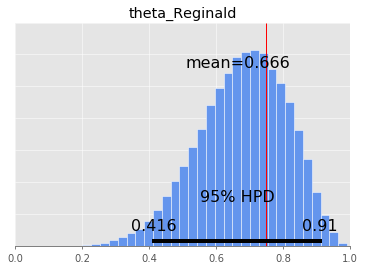

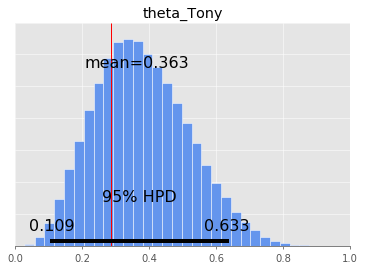

In [12]:
for name in data_df['s'].unique():
    name = 'theta_'+name
    ax = pm.plot_posterior(trace[name], figsize=(10,4), color='cornflowerblue')
    ax.vlines(start[name], ax.get_ylim()[0], ax.get_ylim()[1], color='r')
    ax.set_title(name)
    ax.set_xlim([0,1])

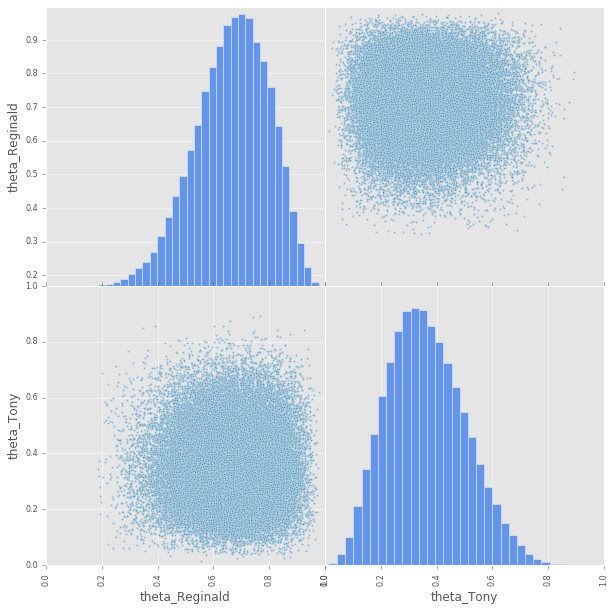

In [13]:
trace_df = pm.trace_to_dataframe(trace)
axs = pd.scatter_matrix(trace_df, figsize=(10,10), diagonal='hist',
                        hist_kwds={'bins':30, 'normed':True, 'color':'cornflowerblue'});
# change default limits to better display results
axs[0,0].set_xlim(0,1)

axs[0,1].set_xlim(0,1)
axs[0,1].set_ylim(0,1)

axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1)

axs[1,1].set_xlim(0,1)

plt.show()

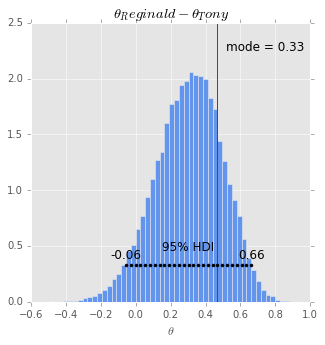

In [14]:
f, ax = plt.subplots(1,1,figsize=(5,5))
delta = trace_df['theta_Reginald'] - trace_df['theta_Tony']
plotPost(delta, ax, r'$\theta_Reginald - \theta_Tony$')

ax.vlines(start['theta_Reginald'] - start['theta_Tony'], ax.get_ylim()[0], ax.get_ylim()[1], color='r')
plt.show()

## 8.5. SAMPLING FROM THE PRIOR DISTRIBUTION

In [15]:
with pm.Model() as model:
    theta1 = pm.Beta('theta1', alpha=2, beta=2, transform=None)
    theta2 = pm.Beta('theta2', alpha=2, beta=2, transform=None)
    
    pm.Deterministic('delta', theta1 - theta2)

    step = pm.Slice()
    # burn in chains
    trace = pm.sample(500, step=step, njobs=4, progressbar=False)
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 10000 of 10000 complete in 51.0 sec

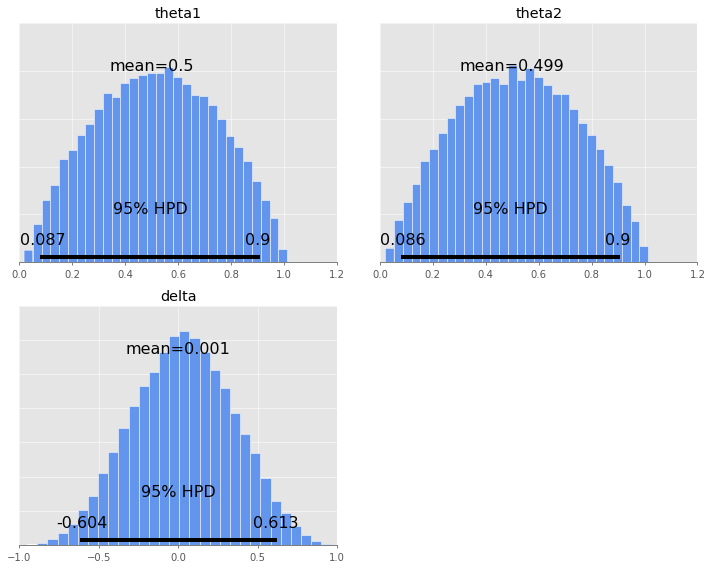

In [16]:
_ = pm.plot_posterior(trace, figsize=(10,8), color='cornflowerblue')

## 8.6.1. Defning new likelihood functions

In [17]:
import theano.tensor as T

In [18]:
# generate test data
y = np.random.randn(100)

### Part A

Define likelihood using native `Normal` function

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

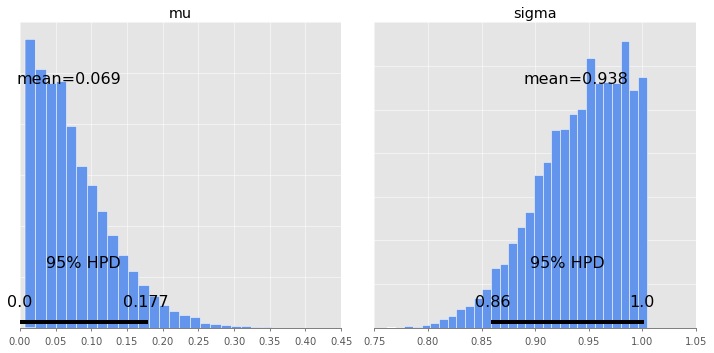

In [19]:
with pm.Model() as model:
    mu = pm.Uniform('mu', transform=None)
    sigma = pm.Uniform('sigma', transform=None)
    tau = 1 / sigma**2
    
    y_hat = pm.Normal('y_hat', mu=mu, tau=tau, observed=y)
        
    step = pm.Metropolis()
    # burn in chains
    trace = pm.sample(500, step=step, njobs=4, progressbar=False)
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)
    
_ = pm.plot_posterior(trace, figsize=(10,5), color='cornflowerblue')

## Part B

Define likelihood by manually implementing the formula for normal distribution

 [-----------------100%-----------------] 10000 of 10000 complete in 2.1 sec

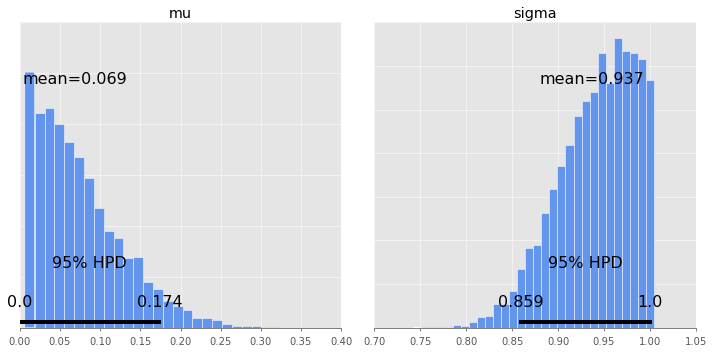

In [20]:
with pm.Model() as model:
    mu = pm.Uniform('mu', transform=None)
    sigma = pm.Uniform('sigma', transform=None)
    
    C = 1000
    e = T.exp( -0.5*((y - mu)/sigma)**2) / (sigma*(2*np.pi)**0.5)
    likelihood = e / C
    
    y_hat = pm.Bernoulli('y_hat', likelihood, observed=np.ones_like(y))
    
    step = pm.Metropolis()
    # burn in chains
    trace = pm.sample(500, step=step, njobs=4, progressbar=False)
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)
    
_ = pm.plot_posterior(trace, figsize=(10,5), color='cornflowerblue')

## Part C

Define likelihood by using `DensityDist`

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

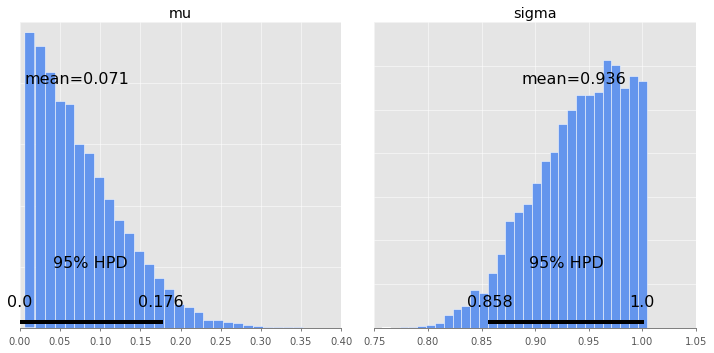

In [21]:
with pm.Model() as model:
    mu = pm.Uniform('mu', transform=None)
    sigma = pm.Uniform('sigma', transform=None)
    
    def likelihood(y):
        return T.exp( -0.5*((y - mu)/sigma)**2) / (sigma*(2*np.pi)**0.5)
    
    # DensityDist requires log probability so transform to log likelihood
    def log_likelihood(y):
        return T.log(likelihood(y))
    
    y_hat = pm.DensityDist('y_hat', log_likelihood, observed=y)
    
    step = pm.Metropolis()
    # burn in chains
    trace = pm.sample(500, step=step, njobs=4, progressbar=False)
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)
    
_ = pm.plot_posterior(trace, figsize=(10,5), color='cornflowerblue')

## Exercise 8.1

**Purpose**: Run the high level scripts with other data to see how easy they are.

In [22]:
# load data and append new fictional entries
data_df = pd.read_csv('../datasets/z6N8z2N7.csv')

new_samples = np.random.rand(50) # sample uniform distribution
new_samples = (new_samples > 0.9).astype(int) # convert to 0s and 1s using threshold
new_category = ['John'] * len(new_samples)
new_entries = list(zip(new_samples, new_category))

data_df = pd.concat((data_df, pd.DataFrame(new_entries, columns=['y', 's'])), ignore_index=True)

In [23]:
data_df.tail(5)

,y,s
60,0,John
61,0,John
62,0,John
63,0,John
64,0,John


In [24]:
# Define the model:
with pm.Model() as model:
    start = {}
    for name, group in data_df.groupby('s'):
        data = group['y'].values
        # Priors for unknown model parameters
        theta = pm.Beta('theta_'+name, alpha=2, beta=2, transform=None)
        # Likelihood (sampling distribution) of observations
        y = pm.Bernoulli('y_'+name, p=theta, observed=data)
        start['theta_'+name] = data.mean()

    # define sampling method
    step = pm.Slice() # similar to Gibbs sampling
    
    # burn in chains
    trace = pm.sample(500, step=step, start=start, njobs=4, progressbar=False)
    
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 10000 of 10000 complete in 86.4 sec

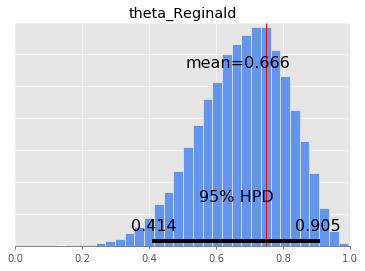

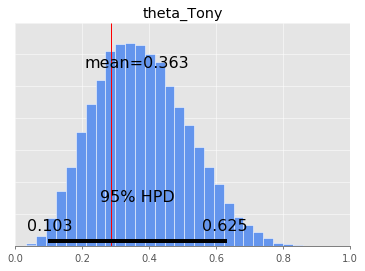

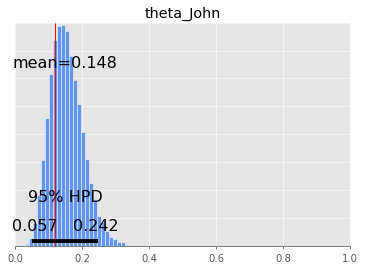

In [25]:
for name in data_df['s'].unique():
    name = 'theta_'+name
    ax = pm.plot_posterior(trace[name], figsize=(10,4), color='cornflowerblue')
    ax.vlines(start[name], ax.get_ylim()[0], ax.get_ylim()[1], color='r')
    ax.set_title(name)
    ax.set_xlim([0,1])

## Exercise 8.2

**Purpose**: Pay attention to the output of ~~`smryMCMC`~~ `summary`

In [26]:
pm.summary(trace)


theta_John:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.148            0.048            0.000            [0.057, 0.242]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.066          0.113          0.144          0.179          0.255


theta_Reginald:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.666            0.130            0.001            [0.414, 0.905]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.390          0.579          0.676          0.762          0.889


theta_Tony:

  Mean             SD               MC Error         95% HPD interval
  ------

In [27]:
# ESS (Effective Sample Size)
pm.effective_n(trace)

{'theta_John': 35711, 'theta_Reginald': 36209, 'theta_Tony': 37203}

## Exercise 8.4

**Purpose**: Explore the prior on a difference of parameters implied from the priors on the individual parameters.

In [28]:
with pm.Model() as model:
    # beta_params = {'alpha': 1, 'beta': 1}
    beta_params = {'alpha': 0.5, 'beta': 0.5}
    theta1 = pm.Beta('theta1', transform=None, **beta_params)
    theta2 = pm.Beta('theta2', transform=None, **beta_params)
    
    pm.Deterministic('delta', theta1 - theta2)

    step = pm.Slice()
    # burn in chains
    trace = pm.sample(500, step=step, njobs=4, progressbar=False)
    # sample the posterior
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 10000 of 10000 complete in 54.7 sec

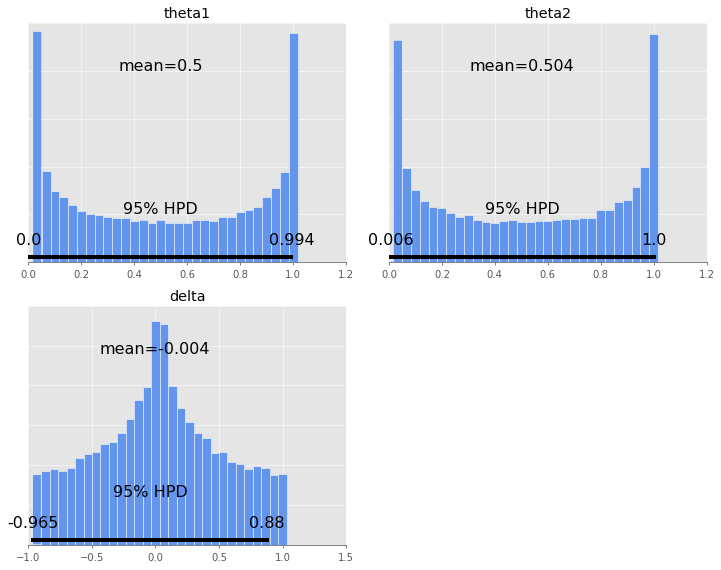

In [29]:
_ = pm.plot_posterior(trace, figsize=(10,8), color='cornflowerblue')